In [1]:
import os
import sys
import json
import joblib
import geopandas as gpd
import torch
import help_functions as hf

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn  # or whatever you need to import
import help_functions as hf

<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [2]:
# Parameters to adapt

run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_21_10_2024/'
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512,256" 
dropout = 0.3
use_dropout = False 
predict_mode_stats = False
in_channels = 13
out_channels = 1 
loss_fct = torch.nn.MSELoss()

# The rest we can usually leave as is
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
pnc_l_string = point_net_conv_layer_structure_local_mlp.replace(',', '_')
pnc_g_string = point_net_conv_layer_structure_global_mlp.replace(',', '_') 
gat_string = gat_conv_layer_structure.replace(',', '_')

unique_model_description = f"pnc_local_[{pnc_l_string}]_" + \
f"pnc_global_[{pnc_g_string}]_" + \
f"gat_conv_[{gat_string}]_" + \
f"use_dropout_{use_dropout}_" + \
f"dropout_{dropout}_" + \
f"predict_mode_stats_{predict_mode_stats}" + "/"
        
run_path = run_path + unique_model_description
base_case_path = '../../data/test_data/pop_1pm_basecase_mean_links_NEW.geojson'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

In [3]:
# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [4]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_3): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
  ))
  (read_out_node_predictions): Linear(in_features=64, out_

In [5]:
# test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

# print(f"Test Loss: {test_loss_my_test_data}")
# print(f"R-squared: {r_squared_my_test_data}")
# print(f"Baseline Loss: {baseline_loss_my_test_data}")

        from_node     to_node  vol_base_case  capacity_base_case  \
15     1001216224      360996      18.745098              4800.0   
16     1001475632   139247803       1.803922               960.0   
17     1001475632      442216       4.019608               960.0   
18      100287503  1835212547       0.313725               480.0   
19      100287503   246999158       2.803922               480.0   
...           ...         ...            ...                 ...   
29650   996976225   996978330      10.745098               720.0   
29651   996978330      360999      10.745098               720.0   
29652   996978330   996976225       5.549020               720.0   
29654   997546279   997546283       0.686275               600.0   
29655   997546283  5148012024       0.686275               600.0   

       capacities_new  capacity_reduction  freespeed  highway      length  \
15             4800.0                 0.0  13.888889      1.0   16.132563   
16              960.0        

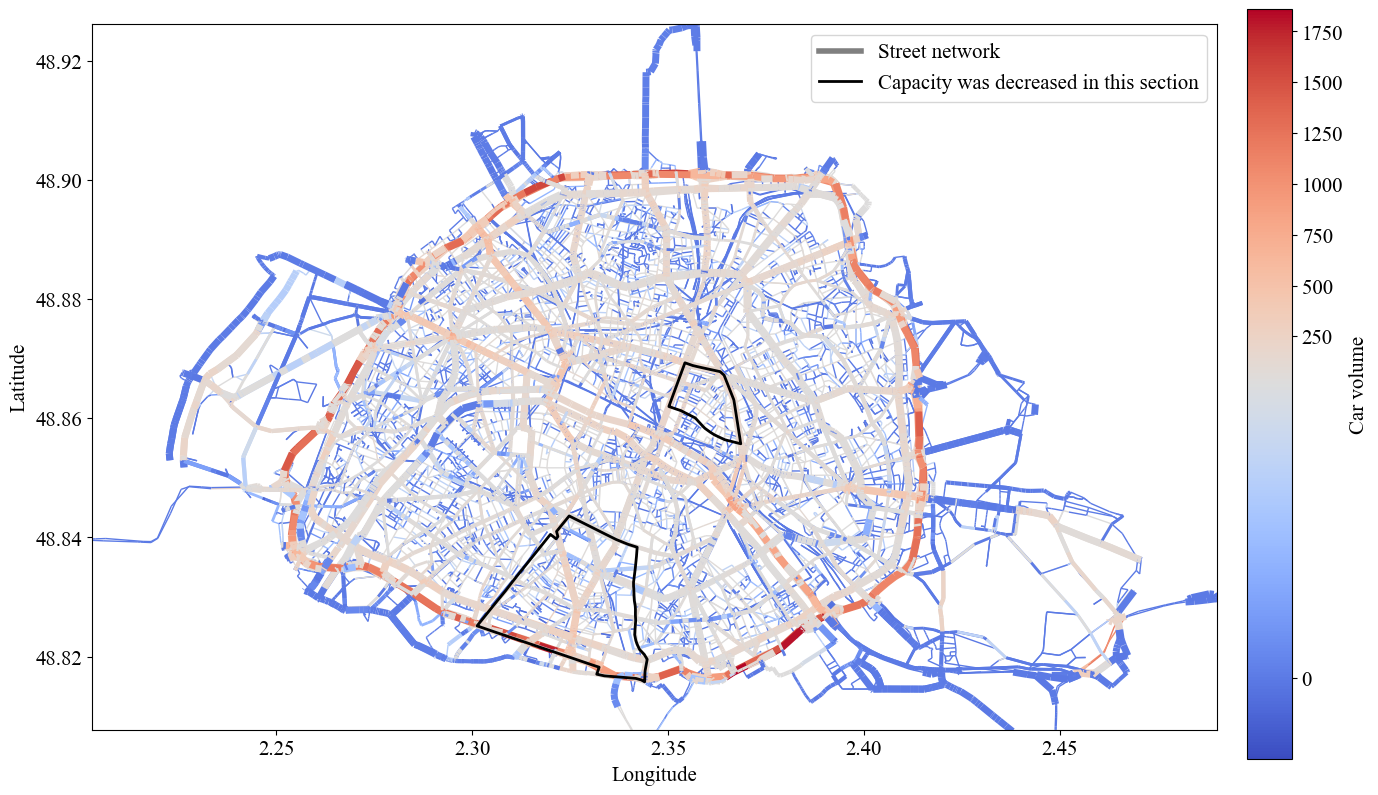

# Next, we will look at single elements of the test set and visualize the performance of the model.


Test 8
Test Loss: 0.3014475504557292
R-squared: 0.5070943832397461
Baseline Loss: 3.6694350242614746


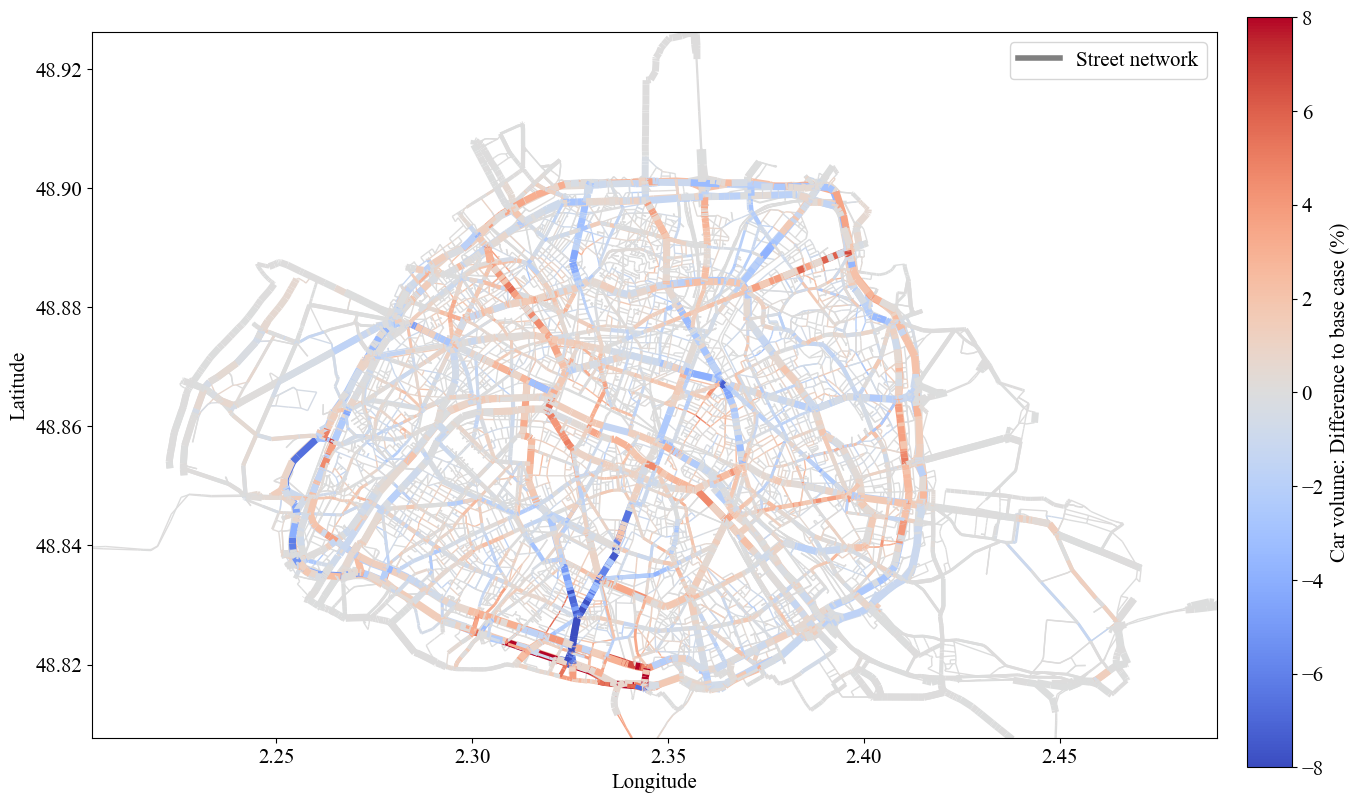

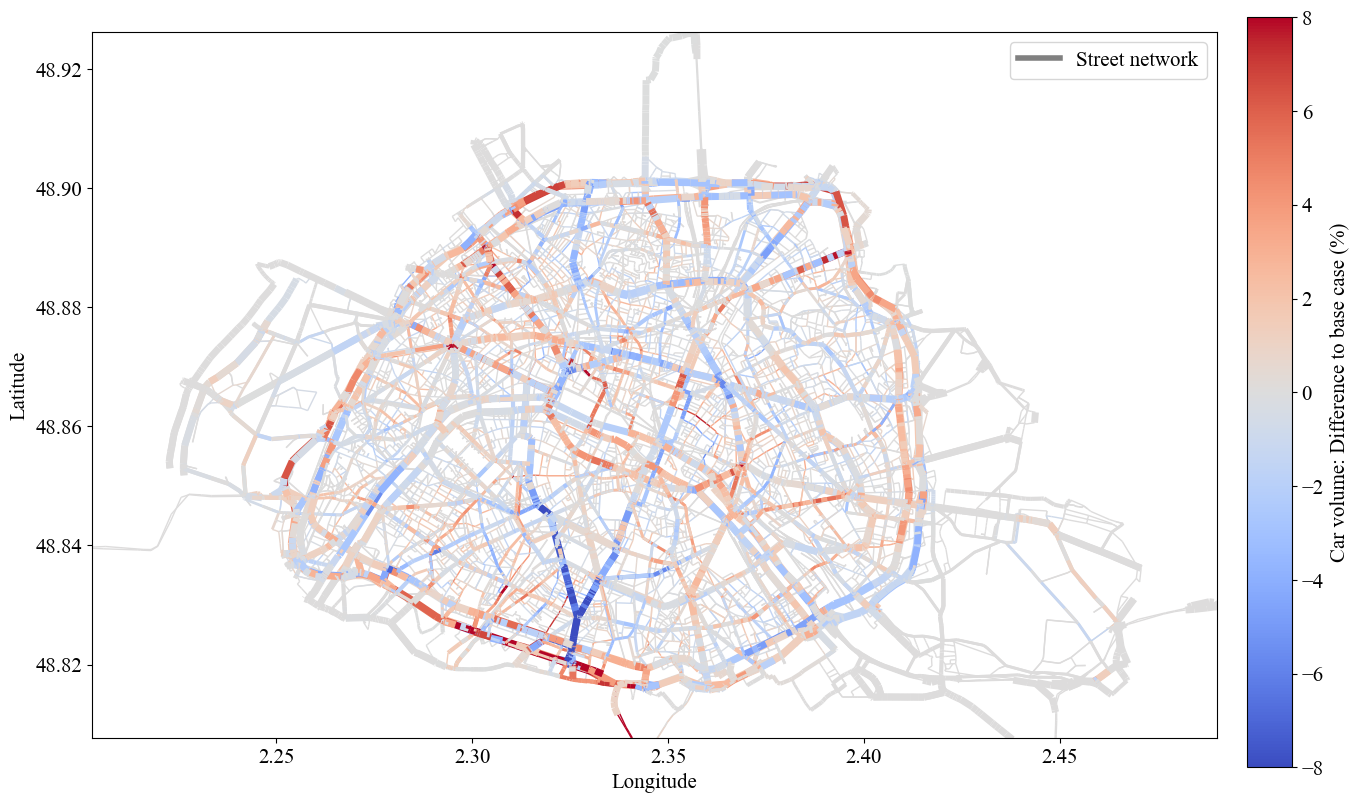

In [7]:
fixed_norm_max = 8

for i in range(10):
    if i != 8:
        continue
    # if i != 14 and i != 21 and i != 33 and i != 38 and i != 39 and i != 45 and i != 58:
    #     continue
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    

    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    print(f"Test {i}")
    print(f"Test Loss: {test_loss_my_test_data}")
    print(f"R-squared: {r_squared_my_test_data}")
    print(f"Baseline Loss: {baseline_loss_my_test_data}")

    inversed_x = scaler_x.inverse_transform(my_test_x)

    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                            save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=False)
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
                            number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=False)

In [ ]:

# PRINT ABSOLUTE CAR VOLUME

non_zero_vol_base_case = gdf_with_og_values[gdf_with_og_values['vol_base_case'] != 0]
non_zero_vol_base_case

gdf_with_og_values['vol_car_predicted'] = (gdf_with_og_values['vol_base_case'] + gdf_with_og_values['vol_car_change_predicted'])*10
gdf_with_og_values.head()

non_zero_vol_base_case = gdf_with_og_values[gdf_with_og_values['vol_base_case'] != 0]
print(non_zero_vol_base_case)


hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_predicted", 
                            save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
                            fixed_norm_max = None,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, is_absolute=True)


In [ ]:
indices_roads_with_highway_primary_sec_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([1,2,3])].index
indices_roads_with_highway_primary_ = gdf_with_og_values[gdf_with_og_values['highway'].isin([1])].index
indices_roads_with_highway_sec = gdf_with_og_values[gdf_with_og_values['highway'].isin([2])].index
indices_roads_with_highway_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([3])].index
indices_roads_with_highway_not_primary_sec_tertiary = gdf_with_og_values[~gdf_with_og_values['highway'].isin([1, 2, 3])].index

tolerance = 1e-3
indices_roads_with_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] < -1e-3].index
indices_roads_with_no_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3].index

indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
].index
indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
].index

def validate_model_on_indices(indices, gdf, loss_fct, loss_fct_aux):
    actual_vals = gdf.loc[indices, 'vol_car_change_actual']
    predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
    actual_vals = actual_vals.to_numpy()
    predicted_vals = predicted_vals.to_numpy()
    actual_mean = torch.mean(torch.tensor(actual_vals))
    mse = loss_fct(torch.tensor(actual_vals), torch.tensor(predicted_vals))
    baseline = loss_fct(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))
    variance = torch.var(loss_fct_aux(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean)))
    r_squared = hf.compute_r2_torch(preds=torch.tensor(predicted_vals), targets=torch.tensor(actual_vals))
    
    baseline = round(baseline.item(), 2)
    mse = round(mse.item(), 2)
    r_squared = round(r_squared.item(), 2)
    variance = round(variance.item(), 2)
    return baseline, mse, r_squared, variance

loss_fct_aux = torch.nn.MSELoss(reduction='none')

baseline_primary_sec_tertiary, mse_primary_sec_tertiary, r_squared_primary_sec_tertiary, variance_primary_sec_tertiary = validate_model_on_indices(indices_roads_with_highway_primary_sec_tertiary, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_primary, mse_primary, r_squared_primary, variance_primary = validate_model_on_indices(indices_roads_with_highway_primary_, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_sec, mse_sec, r_squared_sec, variance_sec = validate_model_on_indices(indices_roads_with_highway_sec, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_tertiary, mse_tertiary, r_squared_tertiary, variance_tertiary = validate_model_on_indices(indices_roads_with_highway_tertiary, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_not_primary_sec_tertiary, mse_not_primary_sec_tertiary, r_squared_not_primary_sec_tertiary, variance_not_primary_sec_tertiary = validate_model_on_indices(indices_roads_with_highway_not_primary_sec_tertiary, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_cap_reduction, mse_cap_reduction, r_squared_cap_reduction, variance_cap_reduction = validate_model_on_indices(indices_roads_with_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_no_cap_reduction, mse_no_cap_reduction, r_squared_no_cap_reduction, variance_no_cap_reduction = validate_model_on_indices(indices_roads_with_no_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_primary_sec_tertiary_and_cap_reduction, mse_primary_sec_tertiary_and_cap_reduction, r_squared_primary_sec_tertiary_and_cap_reduction, variance_primary_sec_tertiary_and_cap_reduction = validate_model_on_indices(indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_primary_sec_tertiary_and_not_cap_reduction, mse_primary_sec_tertiary_and_not_cap_reduction, r_squared_primary_sec_tertiary_and_not_cap_reduction, variance_primary_sec_tertiary_and_not_cap_reduction = validate_model_on_indices(indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)

print("Primary, Secondary, Tertiary Roads - Baseline:", baseline_primary_sec_tertiary, "MSE:", mse_primary_sec_tertiary, "R^2:", r_squared_primary_sec_tertiary, "Variance:", variance_primary_sec_tertiary)
print("Primary Roads - Baseline:", baseline_primary, "MSE:", mse_primary, "R^2:", r_squared_primary, "Variance:", variance_primary)
print("Secondary Roads - Baseline:", baseline_sec, "MSE:", mse_sec, "R^2:", r_squared_sec, "Variance:", variance_sec)
print("Tertiary Roads - Baseline:", baseline_tertiary, "MSE:", mse_tertiary, "R^2:", r_squared_tertiary, "Variance:", variance_tertiary)
print("Non-Primary, Non-Secondary, Non-Tertiary Roads - Baseline:", baseline_not_primary_sec_tertiary, "MSE:", mse_not_primary_sec_tertiary, "R^2:", r_squared_not_primary_sec_tertiary, "Variance:", variance_not_primary_sec_tertiary)
print("Capacity Reduction Roads - Baseline:", baseline_cap_reduction, "MSE:", mse_cap_reduction, "R^2:", r_squared_cap_reduction, "Variance:", variance_cap_reduction)
print("No Capacity Reduction Roads - Baseline:", baseline_no_cap_reduction, "MSE:", mse_no_cap_reduction, "R^2:", r_squared_no_cap_reduction, "Variance:", variance_no_cap_reduction)
print("Primary, Secondary, Tertiary Roads with Capacity Reduction - Baseline:", baseline_primary_sec_tertiary_and_cap_reduction, "MSE:", mse_primary_sec_tertiary_and_cap_reduction, "R^2:", r_squared_primary_sec_tertiary_and_cap_reduction, "Variance:", variance_primary_sec_tertiary_and_cap_reduction)
print("Primary, Secondary, Tertiary Roads with No Capacity Reduction - Baseline:", baseline_primary_sec_tertiary_and_not_cap_reduction, "MSE:", mse_primary_sec_tertiary_and_not_cap_reduction, "R^2:", r_squared_primary_sec_tertiary_and_not_cap_reduction, "Variance:", variance_primary_sec_tertiary_and_not_cap_reduction)

# Convert the GeoDataFrame to the appropriate coordinate reference system (CRS) for length calculation
gdf_in_meters = gdf_with_og_values.to_crs("EPSG:32633")
gdf_in_meters['length'] = gdf_in_meters.length
total_length = gdf_in_meters['length'].sum() / 1000
print(f"Total length of the street network: {total_length:.2f} km")
gdf_with_reductions = gdf_in_meters.loc[indices_roads_with_cap_reduction]
total_length_with_reductions = gdf_with_reductions['length'].sum() / 1000
print(f"Total length of the street network with capacity reductions: {total_length_with_reductions:.2f} km")
# Can do this for all indices

Primary, Secondary, Tertiary Roads - Baseline: 5.06 MSE: 2.13 R^2: 0.58 Variance: 450.7
Primary Roads - Baseline: 8.15 MSE: 2.91 R^2: 0.64 Variance: 969.28
Secondary Roads - Baseline: 2.94 MSE: 1.56 R^2: 0.47 Variance: 37.92
Tertiary Roads - Baseline: 3.13 MSE: 1.71 R^2: 0.45 Variance: 116.19
Non-Primary, Non-Secondary, Non-Tertiary Roads - Baseline: 2.64 MSE: 1.57 R^2: 0.4 Variance: 502.32
Capacity Reduction Roads - Baseline: 23.93 MSE: 4.7 R^2: 0.8 Variance: 3452.57
No Capacity Reduction Roads - Baseline: 2.96 MSE: 1.72 R^2: 0.42 Variance: 329.56
Primary, Secondary, Tertiary Roads with Capacity Reduction - Baseline: 23.93 MSE: 4.7 R^2: 0.8 Variance: 3452.57
Primary, Secondary, Tertiary Roads with No Capacity Reduction - Baseline: 3.45 MSE: 1.93 R^2: 0.44 Variance: 74.01
Total length of the street network: 2829.98 km
Total length of the street network with capacity reductions: 60.15 km
